# **MODELING AFTER DATA CLEANING** #

  With the two data sets (df1 and dfB), we want to:

  (1). Find out which of the two datasets we can use for downstream modelling
    
    - Our assumption is that the dfB (with less data) is better because it requires fewer resources for the computation.
    - however, this can come at the expense of the model performance
    - aprior, we evaluate using XGBoost and RandomForest classifiers, whether performance of these model is similar for both data sets
    - we select the data with better metrics based on the same test set

   (2). Evaluate whether model performance is dependent on the encoding method applied during data pre-processing (*LableEncoder* & *get_dummies*) using the seleted dataset in step (1).
    
    - here as well we use *XGBoost* and *RandomForest Classifier* for testing
    - finally, the encoding method with best metrics is selected for step (3)

   (3). Find the best (accurate) model that gives better prediction (in terms of precision and recall) for the two classes (survivers and dead patient)
    
    - We use six classification models: XGBoost (XGB), RandomForest (RF), LogisticRegression (LR), GradientBoostingClassifier (GBC), Support Vevtor Classifier (SVC), and BalancedRandomForest (BRF)
    - we apply hyperparameter grid to optimize each model parameters
    - Account for data imbalance by applying SMOTE, undersampling, or OversSampling methods
    - finally, we select the model with the best metrics (accuracy, precision, and recall)

  (4). With the best model (step 3), determine the best parameters while accounting for data imbalance
    
    - We use different imbalance techniques for undersampling and oversampling
    - Save the best model

  (5). Compare the model performance with a deep learning model

    - manually optimize the parameters

## **1. Selection of Data To Use** ##
  - Run the same prediction models (`XGBoost` and `RandomForest Classifier`) on both `df1` and `dfB` data sets independently
  
---



1. **Data Preparation**:
   - Split the data into training and test sets
   - Standardize the features of both datasets using `StandardScaler`.

2. **Model Training**:
   - Train the data sets with an XGBoost model and a RandomForest Classifier.
   - Account for feature imbalance.
   - Use GridSeachCV for hyperparameter selection.

3. **Evaluation and Compare**:
   - Evaluate model performance on the same test set
   - Compute accuracy for both models and provide classification report, detailing performance metrics (precision, recall, and F1-score) for each class.





## *1.0 Load preprocessed data and  import libraries* ##

In [21]:
# The dataset was uploaded to drive
# Import data from drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print("If you are working on your local machine this should not be a problem", e)

If you are working on your local machine this should not be a problem No module named 'google.colab'


In [22]:
# For data manipulation and preprocessing
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scaling test and training data sets
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Classifier libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Allows to use a pipeline
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

# For metrics to score the different models
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import make_classification

# To suppress all kinds of warnings
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning

In [23]:
# Ignore warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
# Importing the saved data of df_B and df_1
# Import data encoded with get_dummies
try:
    data = pd.read_csv('/content/drive/MyDrive/Datasets/data.csv', index_col='_INTEGRATION')  #index_col='_INTEGRATION'
    dataB = pd.read_csv('/content/drive/MyDrive/Datasets/dataB.csv', index_col='_INTEGRATION')
    target =pd.read_csv('/content/drive/MyDrive/Datasets/target.csv', index_col='_INTEGRATION')
    targetB = pd.read_csv('/content/drive/MyDrive/Datasets/targetB.csv', index_col='_INTEGRATION')
except FileNotFoundError:
    data = pd.read_csv('../data/dummies/data.csv', index_col='_INTEGRATION')  #index_col='_INTEGRATION'
    dataB = pd.read_csv('../data/dummies/dataB.csv', index_col='_INTEGRATION')
    target =pd.read_csv('../data/dummies/target.csv', index_col='_INTEGRATION')
    targetB = pd.read_csv('../data/dummies/targetB.csv', index_col='_INTEGRATION')

# Printing the shapes of the imported data
data.shape, dataB.shape, target.shape, targetB.shape

((1226, 8885), (632, 5363), (1226, 1), (632, 1))

In [14]:
# Importing the saved data of df_B and df_1
# Import data encoded with label encoder
try:
    df1 = pd.read_csv('/content/drive/MyDrive/Datasets/final_df.csv', index_col='_INTEGRATION') # df1 dataframe
    dfB = pd.read_csv('/content/drive/MyDrive/Datasets/final_dfB.csv',index_col='_INTEGRATION') # dfB dataframe
except FileNotFoundError:
    df1 = pd.read_csv('../data/label_encoder/final_df.csv', index_col='_INTEGRATION') # df1 dataframe
    dfB = pd.read_csv('../data/label_encoder/final_dfB.csv', index_col='_INTEGRATION') # dfB dataframe


label_data = df1.drop('vital_status', axis=1) # data df1 no target
label_dataB = dfB.drop('vital_status', axis=1) # data dfB no target

# Synchronizing indices
label_data.index = data.index
label_dataB.index = dataB.index

# Printing the shape of the imported data
label_data.shape, label_dataB.shape

((1226, 79), (632, 79))

In [15]:
# Deleting the extra column generated by the label encoder
try:
    df1.drop('Unnamed: 0', axis = 1, inplace = True)
    dfB.drop('Unnamed: 0', axis = 1, inplace = True)
except Exception as e:
    print (e)

"['Unnamed: 0'] not found in axis"


### *1.1 Data preparation for modelling*

  - split data into training and test sets

  - scale the feature set with StandardScaler

#### **1.1.1 Import all libraries needed** ###

In [ ]:
# Import required libraries

# general libraies
import pandas as pd
import numpy as np
import csv

# preprocessing libraries
## scaling test and training data sets
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# classifier libraries
## for models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
## for imbalanced data sets
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
## allows to use a pipeline
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
## for metrics to score the different models
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# data plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from sklearn.metrics import plot_confusion_matrix ## not installed in collabo

# other libraries
## to suppress all kinds of warnings
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning) ## add more if needed

#### **1.1.2 Split data set encoded with `LabelEncoder`** ###




In [17]:
# Splitting the dataB into train and test sets: df_B
X_trainB_le, X_testB_le, y_trainB_le, y_test_common_le = train_test_split(label_dataB, targetB, test_size=0.3, random_state=123)

# Extracting the indices of the test instances from X_testB
X_test_common_indices_le = X_testB_le.index

'''X_test_common_indicies now contains the indices of what we want to make a common test set out of
df1 contains all data from dfB
We use the X_test_common_indicies to make a X_test from df1 with the same indicies'''

# Filtering out common test instances from data and its target: df1
X_test_le = label_data.loc[X_test_common_indices_le]
#y_test= target.loc[X_test_common_indices_le]

# Filtering out non-common instances for training set: df1
X_train_le = label_data.drop(X_test_common_indices_le)
y_train_le = target.drop(X_test_common_indices_le)

# Print shapes to verify
print("Shape of LabelEcnoded df1 data :")
print("X_train:", X_train_le.shape)
print("y_train:", y_train_le.shape)
print("X_test:", X_test_le.shape)
print("\n")
print("Shape of LabelEcnoded dfB data :")
print("X_trainB:", X_trainB_le.shape)
print("y_trainB_le:", y_trainB_le.shape)
print("X_testB:", X_testB_le.shape)
print("\n")
print("Shape of y_test common to both :")
print("y_test_common:", y_test_common_le.shape)


Shape of LabelEcnoded df1 data :
X_train: (1036, 79)
y_train: (1036, 1)
X_test: (190, 79)


Shape of LabelEcnoded dfB data :
X_trainB: (442, 79)
y_trainB_le: (442, 1)
X_testB: (190, 79)


Shape of y_test common to both :
y_test_common: (190, 1)


#### **1.1.3 Split data set encoded with `get_dummies`** ###





In [18]:
# Splitting the dataB into train and test sets: df_B
X_trainB_gd, X_testB_gd, y_trainB_gd, y_test_common_gd = train_test_split(dataB, targetB, test_size=0.3, random_state=816)

# Extracting the indices of the test instances from X_testB
X_test_common_indices_gd = X_testB_gd.index

'''X_test_common_indicies now contains the indices of what we want to make a common test set out of
df1 contains all data from dfB
We use the X_test_common_indicies to make a X_test from df1 with the same indicies'''

# Filtering out common test instances from data and its target: df1
X_test_gd = data.loc[X_test_common_indices_gd]
#y_test= target.loc[X_test_common_indices_gd]

# Filtering out non-common instances for training set: df1
X_train_gd = data.drop(X_test_common_indices_gd)
y_train_gd = target.drop(X_test_common_indices_gd)

# Print shapes to verify
print("Shape of get_dummies df1 data :")
print("X_train:", X_train_gd.shape)
print("y_train:", y_train_gd.shape)
print("X_test:", X_test_gd.shape)
print("\n")
print("Shape of get_dummies dfB data :")
print("X_trainB:", X_trainB_gd.shape)
print("y_trainB:", y_trainB_gd.shape)
print("X_testB:", X_testB_gd.shape)
print("\n")
print("Shape of y_test common to both :")
print("y_test_common:", y_test_common_gd.shape)


Shape of get_dummies df1 data :
X_train: (1036, 8885)
y_train: (1036, 1)
X_test: (190, 8885)


Shape of get_dummies dfB data :
X_trainB: (442, 5363)
y_trainB: (442, 1)
X_testB: (190, 5363)


Shape of y_test common to both :
y_test_common: (190, 1)


In [ ]:
# Checking if indices match
indices_match = (y_test_common_gd.index == X_test_common_indices_gd).all() and \
                (X_testB_gd.index == X_test_gd.index).all()

print("Indices match:", indices_match)

Indices match: True


In [20]:
# Printing the indices
print(y_test_common_gd.index), print(X_testB_gd.index), print(X_test_gd.index)

Index(['TCGA-D8-A1JB-01', 'TCGA-D8-A1XS-01', 'TCGA-E2-A14Z-01',
       'TCGA-AN-A0AR-01', 'TCGA-E9-A247-01', 'TCGA-AR-A1AO-01',
       'TCGA-E9-A1RE-01', 'TCGA-C8-A274-01', 'TCGA-AO-A03V-01',
       'TCGA-D8-A1XG-01',
       ...
       'TCGA-AR-A0TY-01', 'TCGA-C8-A12W-01', 'TCGA-B6-A0WY-01',
       'TCGA-A2-A1FX-01', 'TCGA-AR-A1AN-01', 'TCGA-E9-A1R3-01',
       'TCGA-BH-A0BM-01', 'TCGA-BH-A0HO-01', 'TCGA-E9-A1ND-01',
       'TCGA-A2-A1FZ-01'],
      dtype='object', name='_INTEGRATION', length=190)
Index(['TCGA-D8-A1JB-01', 'TCGA-D8-A1XS-01', 'TCGA-E2-A14Z-01',
       'TCGA-AN-A0AR-01', 'TCGA-E9-A247-01', 'TCGA-AR-A1AO-01',
       'TCGA-E9-A1RE-01', 'TCGA-C8-A274-01', 'TCGA-AO-A03V-01',
       'TCGA-D8-A1XG-01',
       ...
       'TCGA-AR-A0TY-01', 'TCGA-C8-A12W-01', 'TCGA-B6-A0WY-01',
       'TCGA-A2-A1FX-01', 'TCGA-AR-A1AN-01', 'TCGA-E9-A1R3-01',
       'TCGA-BH-A0BM-01', 'TCGA-BH-A0HO-01', 'TCGA-E9-A1ND-01',
       'TCGA-A2-A1FZ-01'],
      dtype='object', name='_INTEGRATION', length

(None, None, None)

#### **1.1.4 Scale the `LabelEncoded` and `get_dummies` data sets** ###

In [ ]:
## LabelEncoded df1 data
scaler_le = StandardScaler() #.fit(X_train_le)
X_train_le_scaled = scaler_le.fit_transform(X_train_le)
X_test_le_scaled = scaler_le.transform(X_test_le)

## LabelEncoded dfb data
scalerB_le = StandardScaler() #.fit(X_trainB_le)
X_trainB_le_scaled = scalerB_le.fit_transform(X_trainB_le)
X_testB_le_scaled = scalerB_le.transform(X_testB_le)

X_train_le_scaled.shape, X_trainB_le_scaled.shape, X_test_le_scaled.shape, X_testB_le_scaled.shape

## get_dummies df1 data
scaler_gd = StandardScaler() #.fit(X_train_gd)
X_train_gd_scaled = scaler_gd.fit_transform(X_train_gd)
X_test_gd_scaled = scaler_gd.transform(X_test_gd)

## get_dummies dfb data
scalerB_gd = StandardScaler() #.fit(X_trainB_gd)
X_trainB_gd_scaled = scalerB_gd.fit_transform(X_trainB_gd)
X_testB_gd_scaled = scalerB_gd.transform(X_testB_gd)

X_train_gd_scaled.shape, X_trainB_gd_scaled.shape, X_test_gd_scaled.shape, X_testB_gd_scaled.shape


((1036, 8885), (442, 5363), (190, 8885), (190, 5363))

### *1.2 Perform modelling with `XGBoost` and `RandomForest Classifier`*
    
    - We use the `labelEncoder` data sets (only 80 columns) for faster turn around
    - Run two independent runs for *df1* and *dfB*
    - Account for data imbalance in each case with SMOTE


#### **1.2.1 Testing with the dfB data set** ###

In [25]:
# Define oversampling technique
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define models and hyperparameter grids
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

param_grids = {
    'Random Forest': {'randomforestclassifier__n_estimators': [5, 10, 20, 50, 100], 'randomforestclassifier__max_depth': [None, 10, 20, 30, 50]},
    'XGBoost': {'xgbclassifier__learning_rate': [0.001, 0.1, 0.2], 'xgbclassifier__max_depth': [3, 5, 7, 10], 'xgbclassifier__booster': ['gbtree', 'gblinear']}
} 

# Perform GridSearchCV with SMOTE for each model
best_models = {}
best_model_name = None
best_f1_score = 0

# Specify scoring metric
scoring = {'F1-Score': 'f1'}

print ('Printing the classification reports for dfB')
for model_name, model in models.items():
    # Pipeline without SMOTE
    pipeline_without_smote = make_pipeline(model)
    grid_search_without_smote = GridSearchCV(pipeline_without_smote, param_grids[model_name],
                                             cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_without_smote.fit(X_trainB_le_scaled, y_trainB_le)

    # Pipeline with SMOTE
    pipeline_with_smote = make_pipeline(smote, model)
    grid_search_with_smote = GridSearchCV(pipeline_with_smote, param_grids[model_name],
                                          cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_with_smote.fit(X_trainB_le_scaled, y_trainB_le)

    # Compare results and select the best based on F1-score
    if grid_search_with_smote.best_score_ > best_f1_score:
        best_models[model_name] = grid_search_with_smote.best_estimator_
        best_f1_score = grid_search_with_smote.best_score_
        best_model_name = model_name  # Update the best model name
    else:
        best_models[model_name] = grid_search_without_smote.best_estimator_
        best_f1_score = grid_search_without_smote.best_score_
        best_model_name = model_name  # Update the best model name

    # Print classification reports for SMOTE and non-SMOTE models
    # Test performance on the same test set
    print ('-------------------------------------------------------')
    print(f"Classification Report - {model_name} (Without SMOTE):")
    print(classification_report(y_test_common_le, grid_search_without_smote.best_estimator_.predict(X_testB_le_scaled)))
    print("\n")
    print(f"Classification Report - {model_name} (With SMOTE):")
    print(classification_report(y_test_common_le, grid_search_with_smote.best_estimator_.predict(X_testB_le_scaled)))
    print ('-------------------------------------------------------')
    print("\n")
    # Visualize confusion matrices
    # Train model
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test_common_le, grid_search_without_smote.best_estimator_.predict(X_testB_le_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (Without SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test_common_le, grid_search_with_smote.best_estimator_.predict(X_testB_le_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (With SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.tight_layout()
    plt.show()


Printing the classification reports for dfB


KeyboardInterrupt: 

**After several executions of the code we came to the conclusion XGBoost with SMOTE has the best performance for dfB**

#### **1.2.2 Testing with the df1 data set** ###

In [26]:
# Define oversampling technique
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define models and hyperparameter grids
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

param_grids = {
    'Random Forest': {'randomforestclassifier__n_estimators': [5, 10, 20, 50, 100], 'randomforestclassifier__max_depth': [None, 10, 20, 30, 50]},
    'XGBoost': {'xgbclassifier__learning_rate': [0.001, 0.1, 0.2], 'xgbclassifier__max_depth': [3, 5, 7, 10], 'xgbclassifier__booster': ['gbtree', 'gblinear']}
}

# Perform GridSearchCV with SMOTE for each model
best_models = {}
best_model_name = None
best_f1_score = 0

# Specify scoring metric
scoring = {'F1-Score': 'f1'}
print ('Printing the classification reports for df1')
for model_name, model in models.items():
    # Pipeline without SMOTE
    pipeline_without_smote = make_pipeline(model)
    grid_search_without_smote = GridSearchCV(pipeline_without_smote, param_grids[model_name],
                                             cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_without_smote.fit(X_train_le_scaled, y_train_le)

    # Pipeline with SMOTE
    pipeline_with_smote = make_pipeline(smote, model)
    grid_search_with_smote = GridSearchCV(pipeline_with_smote, param_grids[model_name],
                                          cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_with_smote.fit(X_train_le_scaled, y_train_le)

    # Compare results and select the best based on F1-score
    if grid_search_with_smote.best_score_ > best_f1_score:
        best_models[model_name] = grid_search_with_smote.best_estimator_
        best_f1_score = grid_search_with_smote.best_score_
        best_model_name = model_name  # Update the best model name
    else:
        best_models[model_name] = grid_search_without_smote.best_estimator_
        best_f1_score = grid_search_without_smote.best_score_
        best_model_name = model_name  # Update the best model name

    # Visualize confusion matrices
    # Train model
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test_common_le, grid_search_without_smote.best_estimator_.predict(X_test_le_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (Without SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test_common_le, grid_search_with_smote.best_estimator_.predict(X_test_le_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (With SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.tight_layout()
    plt.show()

    # Print classification reports for SMOTE and non-SMOTE models
    ## Test performance on the same test set
    print ('-------------------------------------------------------')
    print(f"Classification Report - {model_name} (Without SMOTE):")
    print(classification_report(y_test_common_le, grid_search_without_smote.best_estimator_.predict(X_test_le_scaled)))
    print("\n")
    print(f"Classification Report - {model_name} (With SMOTE):")
    print(classification_report(y_test_common_le, grid_search_with_smote.best_estimator_.predict(X_test_le_scaled)))
    print ('-------------------------------------------------------')
    print("\n")

Printing the classification reports for df1


KeyboardInterrupt: 

**We can conclude after several executions XGBoost without SMOTE has the best performance.**

## **2.  Evaluate The Effect Of Data Encoding On Model Performance**
  - Evaluate model performance on `df1`, indepently for data encoded with `LabelEncoder` and `get_dummies`

---

1. **Model Training**:
   - Trains an XGBoost model and a RandomForest Classifier on the training set of `df1`, applying  GridSearchCV for hyperparameter selection as in 1.2.

2. **Evaluation and Compare**:
   - Evaluate model performance on the same test set
   - Compute accuracy for both models and provide classification report, detailing performance metrics (precision, recall, and F1-score) for each class.

### *2.1 Evaluate model performance with `df1` data set encoded with `LabelEncoder`*

Classification Report for df1


-------------------------------------------------------
Classification Report - Random Forest (Without SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       177
           1       0.50      0.38      0.43        13

    accuracy                           0.93       190
   macro avg       0.73      0.68      0.70       190
weighted avg       0.92      0.93      0.93       190



Classification Report - Random Forest (With SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       177
           1       0.50      0.54      0.52        13

    accuracy                           0.93       190
   macro avg       0.73      0.75      0.74       190
weighted avg       0.93      0.93      0.93       190

-------------------------------------------------------




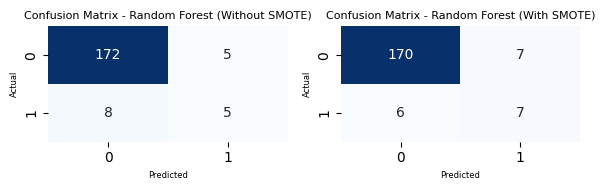

-------------------------------------------------------
Classification Report - XGBoost (Without SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       177
           1       0.57      0.62      0.59        13

    accuracy                           0.94       190
   macro avg       0.77      0.79      0.78       190
weighted avg       0.94      0.94      0.94       190



Classification Report - XGBoost (With SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       177
           1       0.44      0.54      0.48        13

    accuracy                           0.92       190
   macro avg       0.70      0.74      0.72       190
weighted avg       0.93      0.92      0.92       190

-------------------------------------------------------




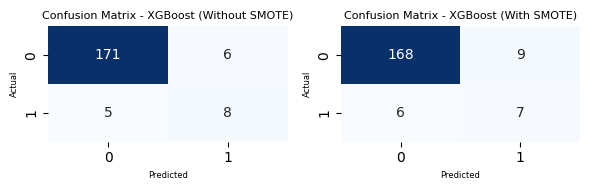

In [ ]:
# Define oversampling technique
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define models and hyperparameter grids
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

param_grids = {
    'Random Forest': {'randomforestclassifier__n_estimators': [5, 10, 20, 50, 100], 'randomforestclassifier__max_depth': [None, 10, 20, 30, 50]},
    'XGBoost': {'xgbclassifier__learning_rate': [0.001, 0.1, 0.2], 'xgbclassifier__max_depth': [3, 5, 7, 10], 'xgbclassifier__booster': ['gbtree', 'gblinear']}
}

# Perform GridSearchCV with SMOTE for each model
best_models = {}
best_model_name = None
best_f1_score = 0

# Specify scoring metric
scoring = {'F1-Score': 'f1'}
print ('Classification Report for df1')
for model_name, model in models.items():
    # Pipeline without SMOTE
    pipeline_without_smote = make_pipeline(model)
    grid_search_without_smote = GridSearchCV(pipeline_without_smote, param_grids[model_name],
                                             cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_without_smote.fit(X_train_le_scaled, y_train_le)

    # Pipeline with SMOTE
    pipeline_with_smote = make_pipeline(smote, model)
    grid_search_with_smote = GridSearchCV(pipeline_with_smote, param_grids[model_name],
                                          cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_with_smote.fit(X_train_le_scaled, y_train_le)

    # Compare results and select the best based on F1-score
    if grid_search_with_smote.best_score_ > best_f1_score:
        best_models[model_name] = grid_search_with_smote.best_estimator_
        best_f1_score = grid_search_with_smote.best_score_
        best_model_name = model_name  # Update the best model name
    else:
        best_models[model_name] = grid_search_without_smote.best_estimator_
        best_f1_score = grid_search_without_smote.best_score_
        best_model_name = model_name  # Update the best model name


   # Print classification reports for SMOTE and non-SMOTE models  
    print ('-------------------------------------------------------')
    print(f"Classification Report - {model_name} (Without SMOTE):")
    print(classification_report(y_test_common_le, grid_search_without_smote.best_estimator_.predict(X_test_le_scaled)))
    print("\n")
    print(f"Classification Report - {model_name} (With SMOTE):")
    print(classification_report(y_test_common_le, grid_search_with_smote.best_estimator_.predict(X_test_le_scaled)))
    print ('-------------------------------------------------------')
    print("\n")

    # Visualize confusion matrices
    # Train model
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test_common_le, grid_search_without_smote.best_estimator_.predict(X_test_le_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (Without SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test_common_le, grid_search_with_smote.best_estimator_.predict(X_test_le_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (With SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.tight_layout()
    plt.show()

**Xboost without SMOTE has the best performance for df1 and for the label encoder**

### *2.2 Evaluate model performance with `df1` data set encoded with `get_dummies`* ##

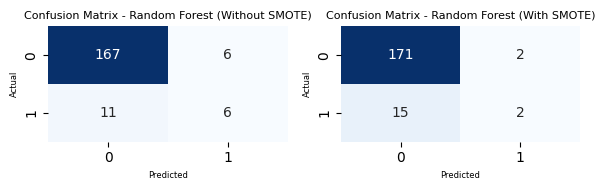

Classification Report - Random Forest (Without SMOTE):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       173
           1       0.50      0.35      0.41        17

    accuracy                           0.91       190
   macro avg       0.72      0.66      0.68       190
weighted avg       0.90      0.91      0.90       190



Classification Report - Random Forest (With SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       173
           1       0.50      0.12      0.19        17

    accuracy                           0.91       190
   macro avg       0.71      0.55      0.57       190
weighted avg       0.88      0.91      0.88       190





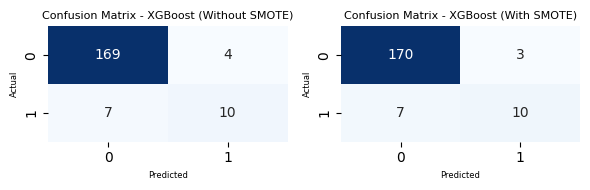

Classification Report - XGBoost (Without SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       173
           1       0.71      0.59      0.65        17

    accuracy                           0.94       190
   macro avg       0.84      0.78      0.81       190
weighted avg       0.94      0.94      0.94       190



Classification Report - XGBoost (With SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       173
           1       0.77      0.59      0.67        17

    accuracy                           0.95       190
   macro avg       0.86      0.79      0.82       190
weighted avg       0.94      0.95      0.94       190



Best model overall: XGBoost
Best F1-Score: 0.64


In [ ]:
# Define oversampling technique
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define models and hyperparameter grids
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

param_grids = {
    'Random Forest': {'randomforestclassifier__n_estimators': [5, 10, 20, 50, 100], 'randomforestclassifier__max_depth': [None, 10, 20, 30, 50]},
    'XGBoost': {'xgbclassifier__learning_rate': [0.001, 0.1, 0.2], 'xgbclassifier__max_depth': [3, 5, 7, 10], 'xgbclassifier__booster': ['gbtree', 'gblinear']}
}

# Perform GridSearchCV with SMOTE for each model
best_models = {}
best_model_name = None
best_f1_score = 0

# Specify scoring metric
scoring = {'F1-Score': 'f1'}

for model_name, model in models.items():
    # Pipeline without SMOTE
    pipeline_without_smote = make_pipeline(model)
    grid_search_without_smote = GridSearchCV(pipeline_without_smote, param_grids[model_name],
                                             cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_without_smote.fit(X_train_gd_scaled, y_train_gd)

    # Pipeline with SMOTE
    pipeline_with_smote = make_pipeline(smote, model)
    grid_search_with_smote = GridSearchCV(pipeline_with_smote, param_grids[model_name],
                                          cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_with_smote.fit(X_train_gd_scaled, y_train_gd)

    # Compare results and select the best based on F1-score
    if grid_search_with_smote.best_score_ > best_f1_score:
        best_models[model_name] = grid_search_with_smote.best_estimator_
        best_f1_score = grid_search_with_smote.best_score_
        best_model_name = model_name  # Update the best model name
    else:
        best_models[model_name] = grid_search_without_smote.best_estimator_
        best_f1_score = grid_search_without_smote.best_score_
        best_model_name = model_name  # Update the best model name

    # Visualize confusion matrices
    # Train model
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test_common_gd, grid_search_without_smote.best_estimator_.predict(X_test_gd_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (Without SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test_common_gd, grid_search_with_smote.best_estimator_.predict(X_test_gd_scaled)),
                annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (With SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.tight_layout()
    plt.show()

    # Print classification reports for SMOTE and non-SMOTE models
    ## Test performance on the same test set
    print(f"Classification Report - {model_name} (Without SMOTE):")
    print(classification_report(y_test_common_gd, grid_search_without_smote.best_estimator_.predict(X_test_gd_scaled)))
    print("\n")
    print(f"Classification Report - {model_name} (With SMOTE):")
    print(classification_report(y_test_common_gd, grid_search_with_smote.best_estimator_.predict(X_test_gd_scaled)))
    print("\n")


**Xboost with SMOTE has the best performance for df1 and for get_dummies**

## **3. Model Selection Using The Retained `df1` Data Set Encoded With `get_dummies`**

  - We evaluate the performance of six models on the same dataset, applying GridSearchCV for hyperparameter selection, while accounting for data imbalance.

In [ ]:
# Define oversampling technique
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define models and hyperparameter grids
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'BalancedRF': BalancedRandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'Support Vector Classifier': SVC(),
    'XGBoost': XGBClassifier()
}

param_grids = {
    'Logistic Regression': {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 200]},
    'Random Forest': {'randomforestclassifier__n_estimators': [5, 10, 20, 50, 100], 'randomforestclassifier__max_depth': [None, 10, 20, 30, 50]},
    'BalancedRF': {'balancedrandomforestclassifier__n_estimators': [10, 20, 50, 100, 200], 'balancedrandomforestclassifier__max_depth': [None, 10, 20, 30, 50]},
    'GradientBoostingClassifier': {'gradientboostingclassifier__n_estimators': [5, 10, 50, 100], 'gradientboostingclassifier__learning_rate': [0.1, 1, 10], 'gradientboostingclassifier__max_depth':[3, 5, 10]},
    'Support Vector Classifier': {'svc__C': [0.001, 0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']},
    'XGBoost': {'xgbclassifier__learning_rate': [0.001, 0.1, 0.2], 'xgbclassifier__max_depth': [3, 5, 7, 10], 'xgbclassifier__booster': ['gbtree', 'gblinear']}
}

# Perform GridSearchCV with SMOTE for each model
best_models = {}
best_model_name = None
best_f1_score = 0

# Specify scoring metric
scoring = {'F1-Score': 'f1'}
print ('Classification report of 6 models of df1 encoded with get_dummies')
for model_name, model in models.items():
    # Pipeline without SMOTE
    pipeline_without_smote = make_pipeline(model)
    grid_search_without_smote = GridSearchCV(pipeline_without_smote, param_grids[model_name],
                                             cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_without_smote.fit(X_train_gd_scaled, y_train_gd)

    # Pipeline with SMOTE
    pipeline_with_smote = make_pipeline(smote, model)
    grid_search_with_smote = GridSearchCV(pipeline_with_smote, param_grids[model_name],
                                          cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)
    grid_search_with_smote.fit(X_train_gd_scaled, y_train_gd)

    # Compare results and select the best based on F1-score
    if grid_search_with_smote.best_score_ > best_f1_score:
        best_models[model_name] = grid_search_with_smote.best_estimator_
        best_f1_score = grid_search_with_smote.best_score_
        best_model_name = model_name  # Update the best model name
    else:
        best_models[model_name] = grid_search_without_smote.best_estimator_
        best_f1_score = grid_search_without_smote.best_score_
        best_model_name = model_name  # Update the best model name

    # Print classification reports for SMOTE and non-SMOTE models
    ## Test performance on the same test set
    print ('-------------------------------------------------------')
    print("\n")
    print(f"Classification Report - {model_name} (Without SMOTE):")
    print(classification_report(y_test_common_gd, grid_search_without_smote.best_estimator_.predict(X_test_gd_scaled)))
    print("\n")
    print(f"Classification Report - {model_name} (With SMOTE):")
    print(classification_report(y_test_common_gd, grid_search_with_smote.best_estimator_.predict(X_test_gd_scaled)))
    print ('-------------------------------------------------------')
    print("\n")

    '''# Visualize confusion matrices
    # Test model
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test_common_gd, grid_search_without_smote.best_estimator_.predict(X_test_gd_scaled)),
                annot=True, fmt='g', cmap='GnBu', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (Without SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test_common_gd, grid_search_with_smote.best_estimator_.predict(X_test_gd_scaled)),
                annot=True, fmt='g', cmap='OrRd', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (With SMOTE)', fontsize=8)
    plt.xlabel('Predicted', fontsize=6)
    plt.ylabel('Actual', fontsize=6)

    plt.tight_layout()
    plt.show()'''


Classification report of 6 models of df1 encoded with get_dummies
-------------------------------------------------------


Classification Report - Logistic Regression (Without SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       173
           1       0.57      0.47      0.52        17

    accuracy                           0.92       190
   macro avg       0.76      0.72      0.74       190
weighted avg       0.92      0.92      0.92       190



Classification Report - Logistic Regression (With SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       173
           1       0.40      0.47      0.43        17

    accuracy                           0.89       190
   macro avg       0.67      0.70      0.69       190
weighted avg       0.90      0.89      0.89       190

-------------------------------------------------------


-------------------------------------------

## **4. Compare XGBoost Model Performance to A Deep Learning Model** AFTER Tuning Parameters

### 4.1 Common Data

#### 4.1.1 **Import data and Library**

In [ ]:
# The dataset was uploaded to drive
# Import data from drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print("If you are working on your local machine this should not be a problem", e)

If you are working on your local machine this should not be a problem No module named 'google.colab'


In [27]:
# For data manipulation and preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Models 
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# For evaluation
from sklearn.metrics import classification_report
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 
import tensorflow as tf
import random

from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dropout

# For resampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN

#Scaler
from sklearn.preprocessing import StandardScaler


In [28]:
# Importing the saved data of df_B and df
# Get dummies data

try:
    data = pd.read_csv('/content/drive/MyDrive/Datasets/data.csv', index_col='_INTEGRATION')  #index_col='_INTEGRATION'
    dataB = pd.read_csv('/content/drive/MyDrive/Datasets/dataB.csv', index_col='_INTEGRATION')
    target =pd.read_csv('/content/drive/MyDrive/Datasets/target.csv', index_col='_INTEGRATION')
    targetB = pd.read_csv('/content/drive/MyDrive/Datasets/targetB.csv', index_col='_INTEGRATION')
except FileNotFoundError:
    data = pd.read_csv('../data/dummies/data.csv', index_col='_INTEGRATION')  #index_col='_INTEGRATION'
    dataB = pd.read_csv('../data/dummies/dataB.csv', index_col='_INTEGRATION')
    target =pd.read_csv('../data/dummies/target.csv', index_col='_INTEGRATION')
    targetB = pd.read_csv('../data/dummies/targetB.csv', index_col='_INTEGRATION')

# printing the shapes
data.shape, dataB.shape, target.shape, targetB.shape

((1226, 8885), (632, 5363), (1226, 1), (632, 1))

In [ ]:
# Importing the saved data of df_B and df
# Label Encoder + Imputed data

try:
    df1 = pd.read_csv('/content/drive/MyDrive/Datasets/final_df.csv', index_col='_INTEGRATION') # df1 dataframe
    dfB = pd.read_csv('/content/drive/MyDrive/Datasets/final_dfB.csv',index_col='_INTEGRATION') # dfB dataframe
except FileNotFoundError:
    df1 = pd.read_csv('../data/label_encoder/final_df.csv', index_col='_INTEGRATION') # df1 dataframe
    dfB = pd.read_csv('../data/label_encoder/final_dfB.csv', index_col='_INTEGRATION') # dfB dataframe


label_data = df1.drop('vital_status', axis=1) # data df1 no target
label_dataB = dfB.drop('vital_status', axis=1) # data dfB no target

# Synchronizing indices
label_data.index = data.index
label_dataB.index = dataB.index

label_data.shape, label_dataB.shape

((1226, 79), (632, 79))

### 4.2 Grid Search with XGBoost `LabelEncoder`


#### 4.2.1 Split data with Label Encoder





In [29]:
X_train, X_test, y_train, y_test = train_test_split(label_data, target, test_size=0.20, random_state=816)
# Print shapes to verify
print("Shapes :")
print("X_train:", X_train.shape)

print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shapes :
X_train: (980, 79)
y_train: (980, 1)
X_test: (246, 79)
y_test: (246, 1)


#### 4.2.2 Scaled Data set


In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((980, 79), (246, 79))

#### 4.2.3 Resampling

In [ ]:
sampling = input('''do you want to resamle data :if no enter "no" if yes enter
"over" for oversampling
"under" for undersampling
"enn" for SOMTEENN
"smote" for smote
"adasyn" for ADASYN : ''')
if sampling == 'under':
  X_train_scaled, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'over':
  X_train_scaled, y_train = RandomOverSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'enn':
  X_train_scaled, y_train = SMOTEENN(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'smote':
  X_train_scaled, y_train = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'adasyn':
  X_train_scaled, y_train = ADASYN(random_state=42, n_neighbors=5, sampling_strategy =1).fit_resample(X_train_scaled, y_train)

X_train_scaled.shape

(980, 79)

#### 4.2.3 Train

In [ ]:
param_grid = {'booster': ['gbtree', 'dart'],  # Adding booster parameter, 'gblinear',
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1,.2, .3],
    'min_child_weight': [1, 3, 5]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid,
                           cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree', 'dart'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [5, 7, 9],
                         'min_child_weight': [1, 3, 5]},
             scoring='accuracy', verbose=2)

In [ ]:
print(grid_search.best_params_)

print(grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_
best_xgb_model

{'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1}
0.95


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### 4.2.4 Results

In [ ]:
# Assuming xgb3 is your trained XGBoost model
y_pred = best_xgb_model.predict(X_test_scaled).round(decimals=0)
y_pred_train = best_xgb_model.predict(X_train_scaled).round(decimals=0)
# Assuming y_test contains the true labels for the test set
report = classification_report(y_test, y_pred)

print(report)
#y_pred.shape, len(y_test)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       208
           1       0.86      0.63      0.73        38

    accuracy                           0.93       246
   macro avg       0.90      0.81      0.84       246
weighted avg       0.92      0.93      0.92       246



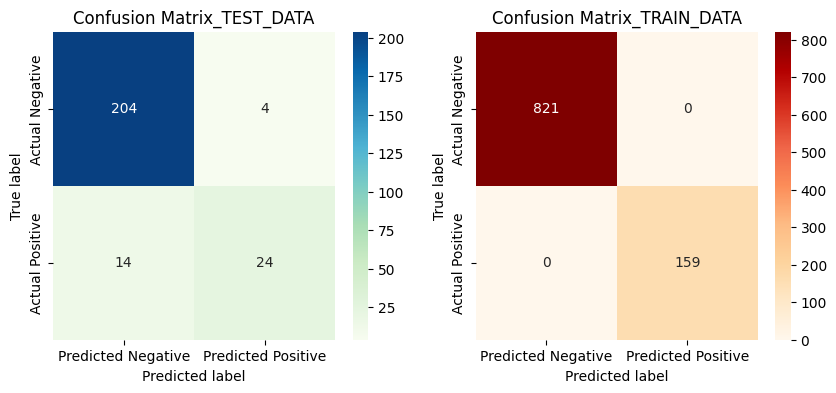

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
test_cm = pd.crosstab(np.array(y_test).flatten(),np.array(y_pred).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='GnBu',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TEST_DATA')

plt.subplot(1,2,2)
test_cm = pd.crosstab(np.array(y_train).flatten(), np.array(y_pred_train).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TRAIN_DATA');

'new_tumor_event_after_initial_treatment'

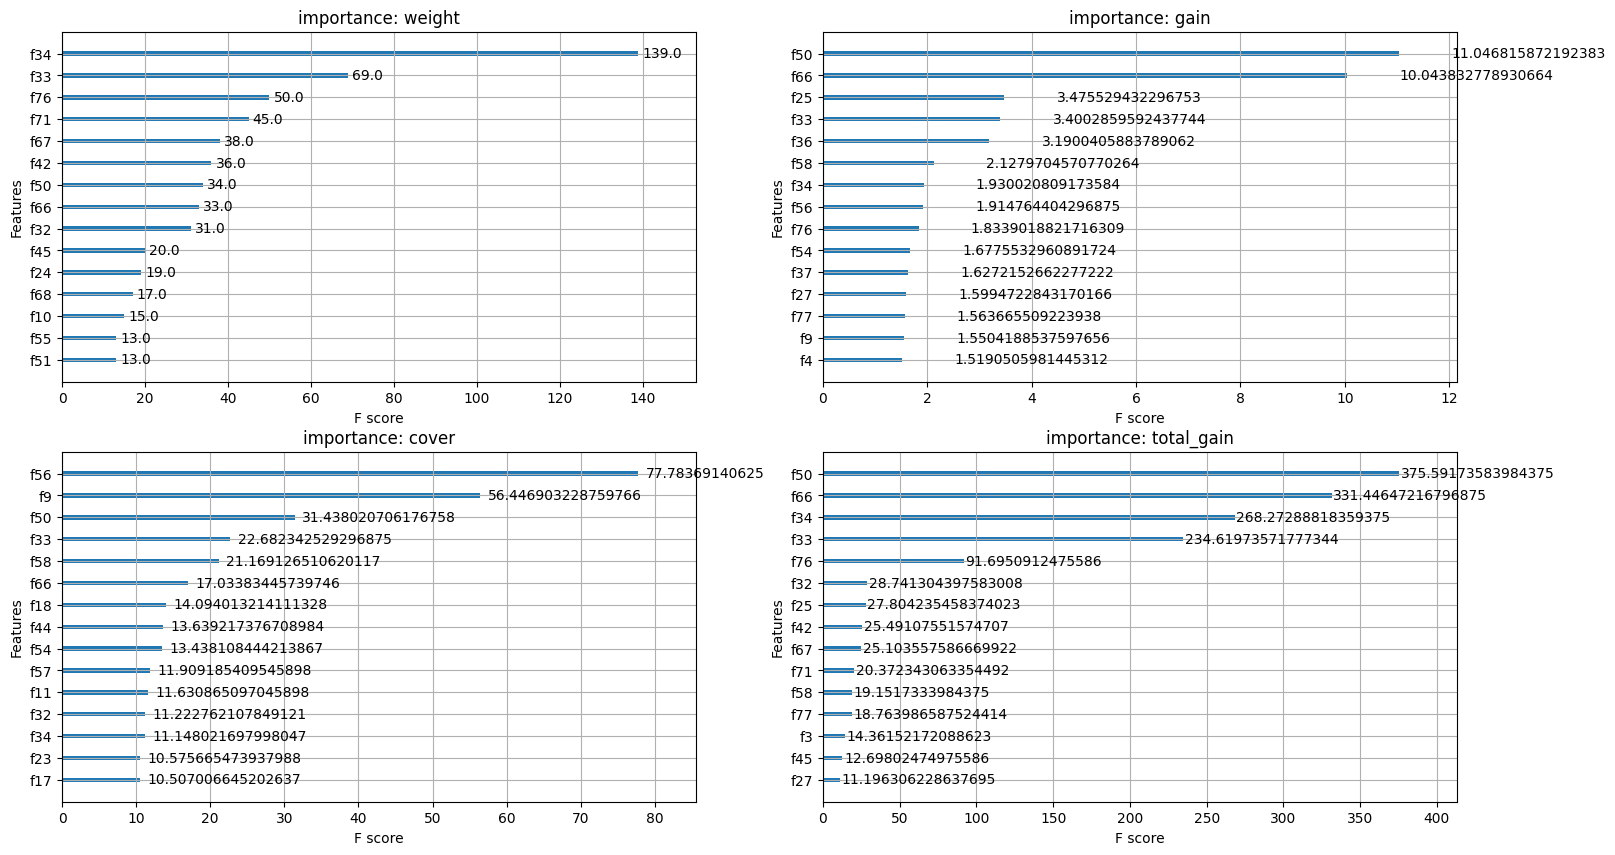

In [ ]:
types = ['weight', 'gain', 'cover', 'total_gain']
num_features = 15

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

for i, f in enumerate(types):
    xgb.plot_importance(best_xgb_model, max_num_features=num_features,
                        importance_type=f, title='importance: ' + f, ax=axes[i // 2, i % 2])
X_test.columns[50]

In [ ]:
print(X_test.columns[50])
print(X_test.columns[53])
print(X_test.columns[34])


new_tumor_event_after_initial_treatment
other_dx
days_to_last_followup


**Weight**: This represents the **number of times a feature appears in a tree** across all trees in the model. Features with higher weights are generally more important.

**Gain**: This measures the improvement in **accuracy** brought by a feature to the model. It calculates the average gain of splits which use the feature.

**Cover**: This represents the relative quantity of observations concerned by a feature. It is defined as the **number of observations affected by a split using the feature.**

**Total Gain**: This measures the **total gain of the feature** when it is used in splits.

[0]	validation_0-error:0.16224	validation_1-error:0.15447
[1]	validation_0-error:0.06429	validation_1-error:0.08943
[2]	validation_0-error:0.03980	validation_1-error:0.07317
[3]	validation_0-error:0.03061	validation_1-error:0.08130
[4]	validation_0-error:0.03061	validation_1-error:0.08537
[5]	validation_0-error:0.02653	validation_1-error:0.08537
[6]	validation_0-error:0.02653	validation_1-error:0.08537
[7]	validation_0-error:0.02143	validation_1-error:0.08537
[8]	validation_0-error:0.01837	validation_1-error:0.08943
[9]	validation_0-error:0.01429	validation_1-error:0.07724
[10]	validation_0-error:0.01531	validation_1-error:0.07724
[11]	validation_0-error:0.01224	validation_1-error:0.07724
[12]	validation_0-error:0.00918	validation_1-error:0.07317
[13]	validation_0-error:0.00918	validation_1-error:0.07317
[14]	validation_0-error:0.00612	validation_1-error:0.07317
[15]	validation_0-error:0.00714	validation_1-error:0.07317
[16]	validation_0-error:0.00408	validation_1-error:0.06911
[17]	va

[92]	validation_0-error:0.00000	validation_1-error:0.07724
[93]	validation_0-error:0.00000	validation_1-error:0.07317
[94]	validation_0-error:0.00000	validation_1-error:0.07724
[95]	validation_0-error:0.00000	validation_1-error:0.07724
[96]	validation_0-error:0.00000	validation_1-error:0.07724
[97]	validation_0-error:0.00000	validation_1-error:0.07317
[98]	validation_0-error:0.00000	validation_1-error:0.07317
[99]	validation_0-error:0.00000	validation_1-error:0.07317


c:\Users\CSO_c\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


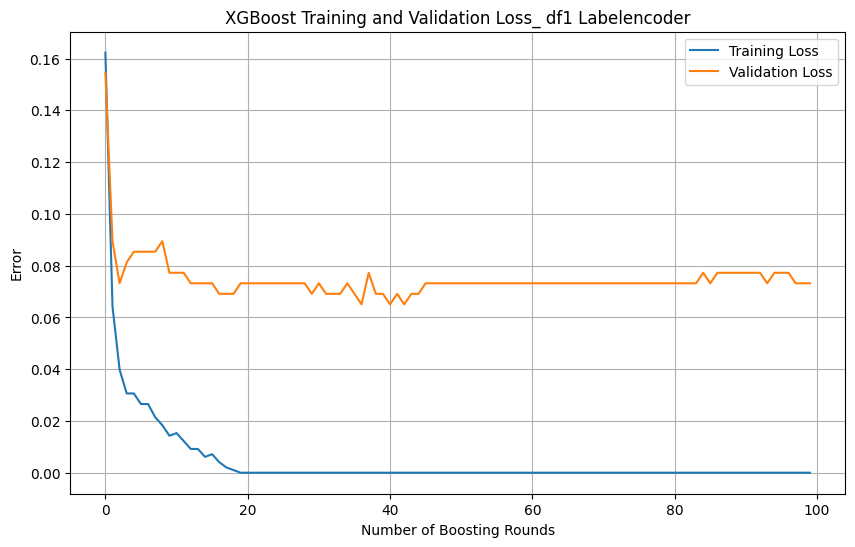

In [ ]:
best_xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], eval_metric='error')

evals_result = best_xgb_model.evals_result()

# Extract the training and validation loss
train_loss = evals_result['validation_0']['error']
val_loss = evals_result['validation_1']['error']
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Training and Validation Loss_ df1 Labelencoder')
plt.legend()
plt.grid(True)

### 4.3 Grid Search with XGBoost get_dummies


#### 4.3.1 Split data with get_dummies





In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=816)
# Print shapes to verify
print("Shapes :")
print("X_train:", X_train.shape)

print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shapes :
X_train: (980, 8885)
y_train: (980, 1)
X_test: (246, 8885)
y_test: (246, 1)


#### 4.3.2 Scaled Data set


In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((980, 8885), (246, 8885))

#### 4.3.3 Resampling

In [ ]:
sampling = input('''do you want to resamle data :if no enter "no" if yes enter
"over" for oversampling
"under" for undersampling
"enn" for SOMTEENN
"smote" for smote
"adasyn" for ADASYN : ''')
if sampling == 'under':
  X_train_scaled, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'over':
  X_train_scaled, y_train = RandomOverSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'enn':
  X_train_scaled, y_train = SMOTEENN(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'smote':
  X_train_scaled, y_train = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'adasyn':
  X_train_scaled, y_train = ADASYN(random_state=42, n_neighbors=5, sampling_strategy =1).fit_resample(X_train_scaled, y_train)

X_train_scaled.shape

(1607, 8885)

#### 4.3.4 Train

In [ ]:
param_grid = {'booster': ['gbtree', 'dart'],  # Adding booster parameter, 'gblinear',
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1,.2, .3],
    'min_child_weight': [1, 3, 5]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid,
                           cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree', 'dart'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [5, 7, 9],
                         'min_child_weight': [1, 3, 5]},
             scoring='accuracy', verbose=2)

In [ ]:
print(grid_search.best_params_)

print(grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_
best_xgb_model

{'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3}
0.9259818590732514


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### 4.3.5 Results

In [ ]:
# Assuming xgb3 is your trained XGBoost model
y_pred = best_xgb_model.predict(X_test_scaled).round(decimals=0)
y_pred_train = best_xgb_model.predict(X_train_scaled).round(decimals=0)
# Assuming y_test contains the true labels for the test set
report = classification_report(y_test, y_pred)

print(report)
#y_pred.shape, len(y_test)


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       208
           1       0.76      0.68      0.72        38

    accuracy                           0.92       246
   macro avg       0.85      0.82      0.84       246
weighted avg       0.92      0.92      0.92       246



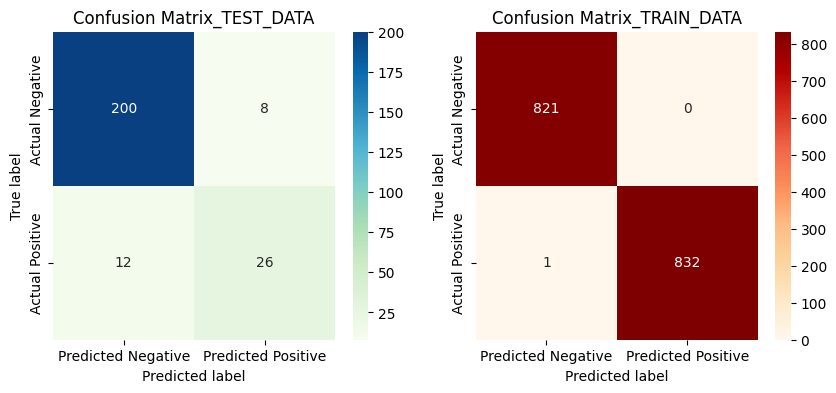

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
test_cm = pd.crosstab(np.array(y_test).flatten(),np.array(y_pred).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='GnBu',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TEST_DATA')

plt.subplot(1,2,2)
test_cm = pd.crosstab(np.array(y_train).flatten(), np.array(y_pred_train).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TRAIN_DATA');

NameError: name 'best_xgb_model' is not defined

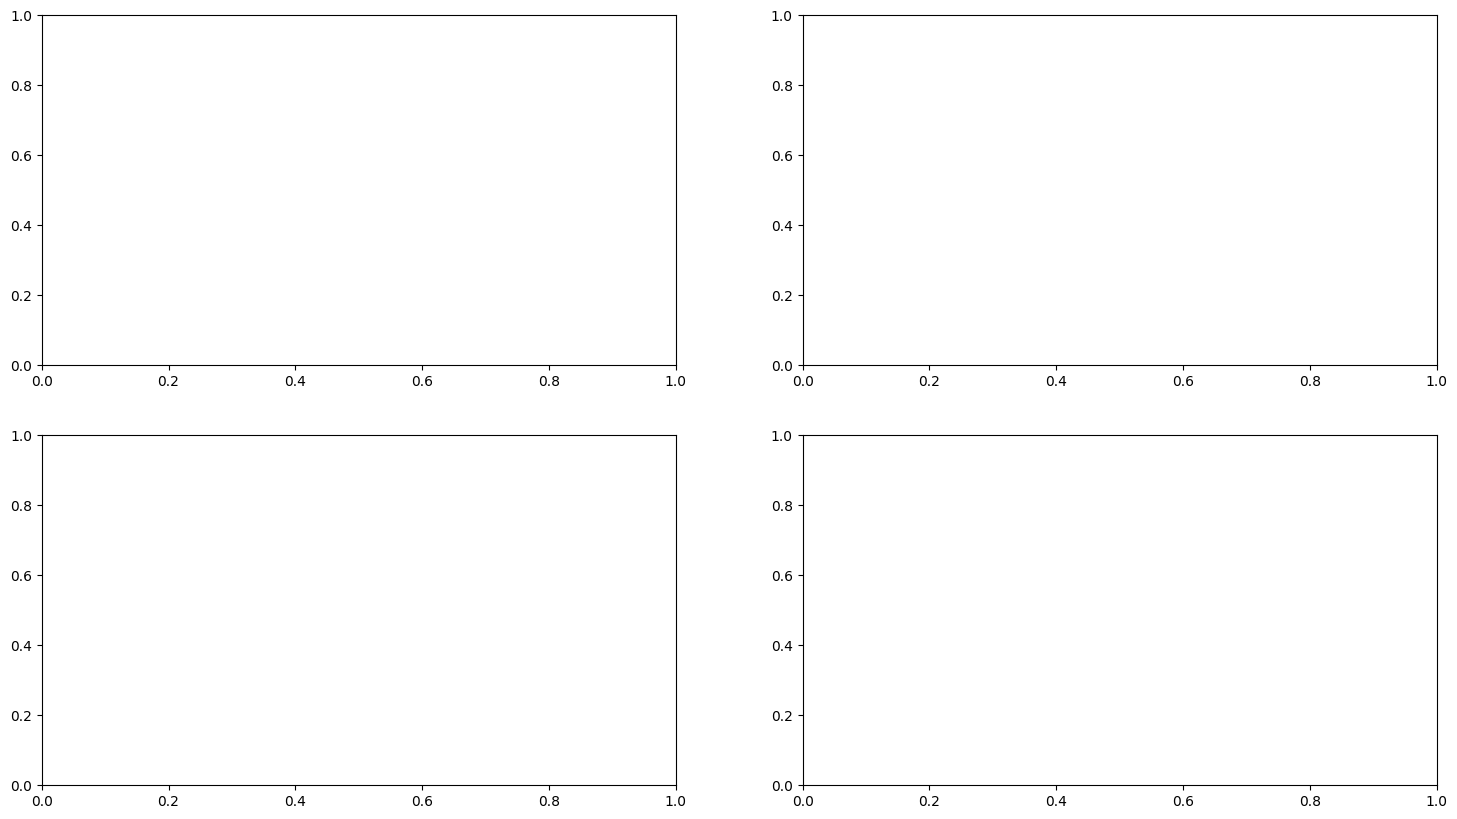

In [52]:
#types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
types = ['weight', 'gain', 'cover', 'total_gain']
num_features = 15

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

for i, f in enumerate(types):
    xgb.plot_importance(best_xgb_model, max_num_features=num_features,
                        importance_type=f, title='importance: ' + f, ax=axes[i // 2, i % 2])
X_test.columns[50]

In [ ]:
print(X_test.columns[50])
print(X_test.columns[53])
print(X_test.columns[34])

new_tumor_event_after_initial_treatment
other_dx
days_to_last_followup


**Weight**: This represents the **number of times a feature appears in a tree** across all trees in the model. Features with higher weights are generally more important.

**Gain**: This measures the improvement in **accuracy** brought by a feature to the model. It calculates the average gain of splits which use the feature.

**Cover**: This represents the relative quantity of observations concerned by a feature. It is defined as the **number of observations affected by a split using the feature.**

**Total Gain**: This measures the **total gain of the feature** when it is used in splits.

[0]	validation_0-error:0.07678	validation_1-error:0.17073
[1]	validation_0-error:0.05804	validation_1-error:0.15041
[2]	validation_0-error:0.05139	validation_1-error:0.15041
[3]	validation_0-error:0.04655	validation_1-error:0.13821
[4]	validation_0-error:0.04051	validation_1-error:0.13008
[5]	validation_0-error:0.03748	validation_1-error:0.12602
[6]	validation_0-error:0.03628	validation_1-error:0.13008
[7]	validation_0-error:0.03748	validation_1-error:0.12602
[8]	validation_0-error:0.03446	validation_1-error:0.12602
[9]	validation_0-error:0.03144	validation_1-error:0.12602
[10]	validation_0-error:0.02902	validation_1-error:0.12195
[11]	validation_0-error:0.02539	validation_1-error:0.12195
[12]	validation_0-error:0.02539	validation_1-error:0.12602
[13]	validation_0-error:0.02177	validation_1-error:0.11382
[14]	validation_0-error:0.02116	validation_1-error:0.11789
[15]	validation_0-error:0.01632	validation_1-error:0.11789
[16]	validation_0-error:0.01693	validation_1-error:0.10976
[17]	va

c:\Users\CSO_c\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


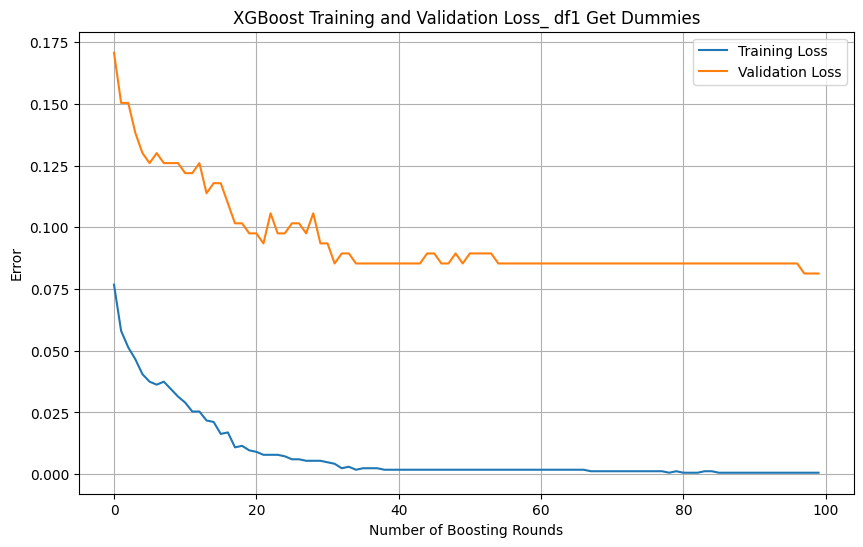

In [ ]:
best_xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], eval_metric='error')

evals_result = best_xgb_model.evals_result()

# Extract the training and validation loss
train_loss = evals_result['validation_0']['error']
val_loss = evals_result['validation_1']['error']
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Training and Validation Loss_ df1 Get Dummies')
plt.legend()
plt.grid(True)

### 4.4 Deep Learning with `LabelEncoder`

#### 4.4.1 Split data with label_encoder




In [59]:
X_train, X_test, y_train, y_test = train_test_split(label_data, target, test_size=0.20, random_state=816)
# Print shapes to verify
print("Shapes :")
print("X_train:", X_train.shape)

print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes :
X_train: (980, 79)
y_train: (980, 1)
X_test: (246, 79)
y_test: (246, 1)


#### 4.4.2 Scaled Data set


In [60]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((980, 79), (246, 79))

#### 4.4.3 Resampling

In [61]:
sampling = input('''do you want to resamle data :if no enter "no" if yes enter
"over" for oversampling
"under" for undersampling
"enn" for SOMTEENN
"smote" for smote
"adasyn" for ADASYN : ''')
if sampling == 'under':
  X_train_scaled, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'over':
  X_train_scaled, y_train = RandomOverSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'enn':
  X_train_scaled, y_train = SMOTEENN(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'smote':
  X_train_scaled, y_train = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'adasyn':
  X_train_scaled, y_train = ADASYN(random_state=42, n_neighbors=5, sampling_strategy =1).fit_resample(X_train_scaled, y_train)

X_train_scaled.shape

(1653, 79)

#### 4.4.3 Train

In [71]:
from keras.layers import BatchNormalization
from keras.regularizers import l2

seed_value = 123
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

inputs = Input(shape=(X_train_scaled.shape[1],))
d1 = Dense(100, activation='relu', kernel_regularizer=l2(0.08))# to avoid overfitting with weight on loss function
b1 = BatchNormalization(epsilon=0.001)
do1 = Dropout(rate=0.3) # to avoid overfitting

d2 = Dense(200, activation='relu', kernel_regularizer=l2(0.1))# to avoid overfitting with weight on loss function
b2 = BatchNormalization(epsilon=0.01)
do2 = Dropout(rate=0.4) # to avoid overfitting
b3 = BatchNormalization() # to speed up training and improving model performance

d3 = Dense(16, activation='relu', kernel_regularizer=l2(0.010))
b3 = BatchNormalization() # to speed up training and improving model performance
do3 = Dropout(rate=.05)


In [72]:
x = d1(inputs)
x = b1(x)
x = do1(x)
x = d2(x)
x = b2(x)
x = do2(x)
x = d3(x)
#x = b3(x)
#x = do3(x)

outputs = output(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 100)            │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,633 (127.47 KB)

 Trainable params: 32,033 (125.13 KB)

 Non-trainable params: 600 (2.34 KB)

In [79]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

class_labels = np.unique(y_train)

# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', loss_weights=[.5], metrics=['accuracy'])

# Train the model on df1
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
#history_df1 = model.fit(X_train_scaled, y_train, epochs=20, batch_size=50, validation_split=0.2,callbacks=[checkpoint], class_weight=class_weights)
history_df1 = model.fit(X_train_scaled, y_train, epochs=23, batch_size=100, validation_data=(X_test_scaled, y_test),  callbacks=[checkpoint])#, class_weight={0: 1, 1: 2})
model.load_weights('best_model.keras')

ValueError: Expected `loss_weights` argument to be a list, tuple, or dict. Received instead: loss_weights=0.5 of type <class 'float'>

#### 4.4.4 Results

In [65]:
# Predictions for df1
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.51).astype(int)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


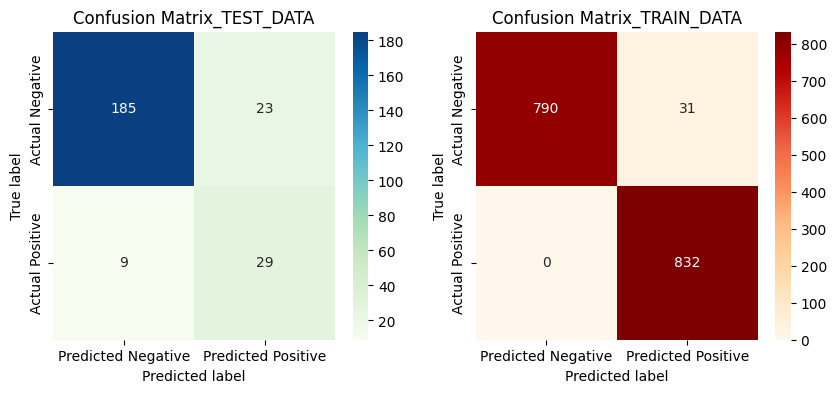

In [66]:
y_pred_prob_train = model.predict(X_train_scaled)
y_pred_train = (y_pred_prob_train > 0.5).astype(int)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
test_cm = pd.crosstab(np.array(y_test).flatten(),np.array(y_pred).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='GnBu',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TEST_DATA')

plt.subplot(1,2,2)
test_cm = pd.crosstab(np.array(y_train).flatten(), np.array(y_pred_train).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TRAIN_DATA');

In [67]:
val_acc = history_df1.history['val_accuracy']
val_loss = history_df1.history['val_loss']
acc = history_df1.history['accuracy']
loss = history_df1.history['loss']
num = len(history_df1.history['val_accuracy'])

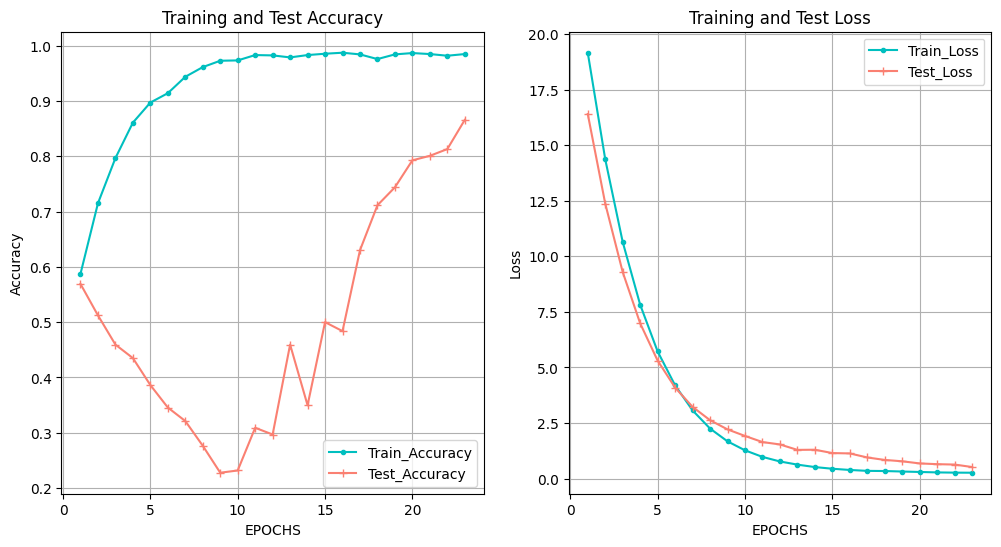

In [68]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(1, num+1), acc, color='c', marker='.', label='Train_Accuracy')
plt.plot(range(1, num+1), val_acc, color='salmon', marker='+', label='Test_Accuracy')
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title('Training and Test Accuracy')
plt.subplot(1,2,2)
plt.plot(range(1, num+1), loss, color='c', marker='.', label='Train_Loss')
plt.plot(range(1, num+1), val_loss, color='salmon', marker='+', label='Test_Loss')
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title('Training and Test Loss');

In [69]:
print("Classification Report for df1 with Deep Learning model:")
print(classification_report(y_test, y_pred))

Classification Report for df1 with Deep Learning model:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       208
           1       0.56      0.76      0.64        38

    accuracy                           0.87       246
   macro avg       0.76      0.83      0.78       246
weighted avg       0.89      0.87      0.88       246



### 4.5 Deep Learning with get_dummies


#### 4.5.1 Split data with get_dummies





In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=816)
# Print shapes to verify
print("Shapes :")
print("X_train:", X_train.shape)

print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shapes :
X_train: (980, 8885)
y_train: (980, 1)
X_test: (246, 8885)
y_test: (246, 1)


#### 4.5.2 Scaled Data set


In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((980, 8885), (246, 8885))

#### 4.5.3 Resampling

In [ ]:
sampling = input('''do you want to resamle data :if no enter "no" if yes enter
"over" for oversampling
"under" for undersampling
"enn" for SOMTEENN
"smote" for smote
"adasyn" for ADASYN : ''')
if sampling == 'under':
  X_train_scaled, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'over':
  X_train_scaled, y_train = RandomOverSampler(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'enn':
  X_train_scaled, y_train = SMOTEENN(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'smote':
  X_train_scaled, y_train = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
elif sampling == 'adasyn':
  X_train_scaled, y_train = ADASYN(random_state=42, n_neighbors=5, sampling_strategy =1).fit_resample(X_train_scaled, y_train)

X_train_scaled.shape

(1607, 8885)

#### 4.5.4 Train

In [55]:
from keras.layers import BatchNormalization
from keras.regularizers import l2

seed_value = 123
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

inputs = Input(shape=(X_train_scaled.shape[1],))
d1 = Dense(100, activation='relu', kernel_regularizer=l2(0.08))# to avoid overfitting with weight on loss function
b1 = BatchNormalization(epsilon=0.001)
do1 = Dropout(rate=0.4) # to avoid overfitting

d2 = Dense(400, activation='relu', kernel_regularizer=l2(0.1))# to avoid overfitting with weight on loss function
b2 = BatchNormalization(epsilon=0.001)
do2 = Dropout(rate=0.3) # to avoid overfitting
b3 = BatchNormalization() # to speed up training and improving model performance

d3 = Dense(16, activation='relu', kernel_regularizer=l2(0.12))#LeakyReLU
b3 = BatchNormalization() # to speed up training and improving model performance
do3 = Dropout(rate=.4)

output = Dense(1, activation='sigmoid')


x = d1(inputs)
x = b1(x)
x = do1(x)
x = d2(x)
#x = b2(x)
x = do2(x)
x = d3(x)
#x = b3(x)
x = do3(x)
outputs = output(x)

model = Model(inputs=inputs, outputs=outputs)
#model.summary()

In [50]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

class_labels = np.unique(y_train)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on df1
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
#history_df1 = model.fit(X_train_scaled, y_train, epochs=20, batch_size=50, validation_split=0.2,callbacks=[checkpoint], class_weight=class_weights)
history_df1 = model.fit(X_train_scaled, y_train, epochs=23, batch_size=100, validation_data=(X_test_scaled, y_test),  callbacks=[checkpoint])#, class_weight={0: 1, 1: 2})
model.load_weights('best_model.keras')

Epoch 1/23
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5656 - loss: 27.1564

KeyboardInterrupt: 

#### 4.5.4 Results

In [ ]:
# Predictions for df1
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
# Classification report for df1 with Deep Learning model
print("Classification Report for df1_get_dummies with Deep Learning model: ")
print(classification_report(y_test, y_pred))

Classification Report for df1_get_dummies with Deep Learning model: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       208
           1       0.88      0.58      0.70        38

    accuracy                           0.92       246
   macro avg       0.90      0.78      0.83       246
weighted avg       0.92      0.92      0.92       246



51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


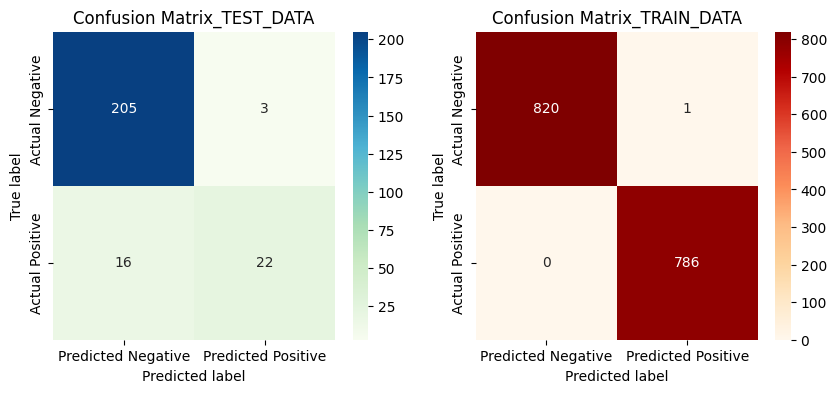

In [ ]:
y_pred_prob_train = model.predict(X_train_scaled)
y_pred_train = (y_pred_prob_train > 0.5).astype(int)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
test_cm = pd.crosstab(np.array(y_test).flatten(),np.array(y_pred).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='GnBu',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TEST_DATA')

plt.subplot(1,2,2)
test_cm = pd.crosstab(np.array(y_train).flatten(), np.array(y_pred_train).flatten())
sns.heatmap(test_cm, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix_TRAIN_DATA');

In [ ]:
val_acc = history_df1.history['val_accuracy']
val_loss = history_df1.history['val_loss']
acc = history_df1.history['accuracy']
loss = history_df1.history['loss']
num = len(history_df1.history['val_accuracy'])

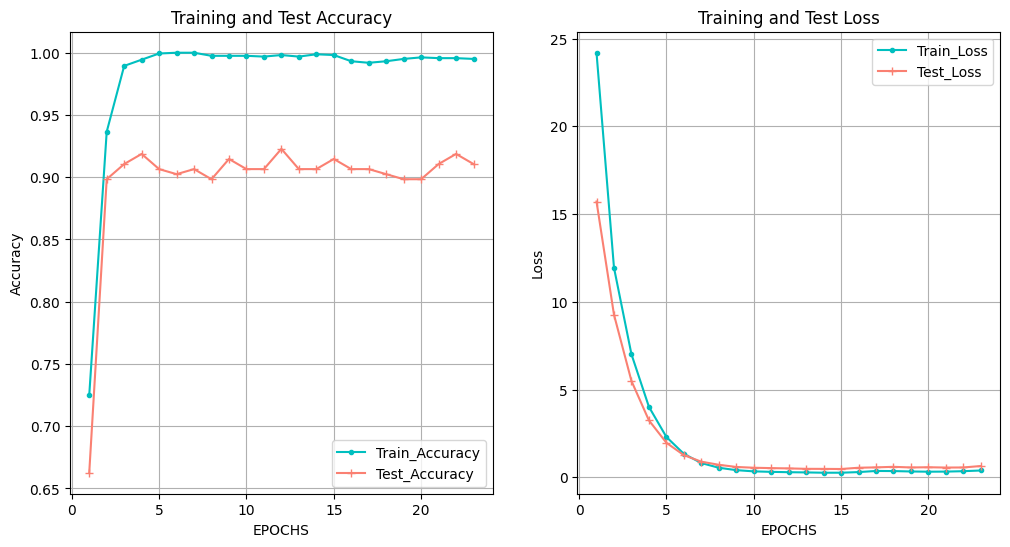

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(1, num+1), acc, color='c', marker='.', label='Train_Accuracy')
plt.plot(range(1, num+1), val_acc, color='salmon', marker='+', label='Test_Accuracy')
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title('Training and Test Accuracy')
plt.subplot(1,2,2)
plt.plot(range(1, num+1), loss, color='c', marker='.', label='Train_Loss')
plt.plot(range(1, num+1), val_loss, color='salmon', marker='+', label='Test_Loss')
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title('Training and Test Loss');